In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
import seaborn as sns
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import warnings
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import matplotlib as mpl

warnings.simplefilter(action="ignore", category=FutureWarning)

#Read in the data
df = pd.read_csv('Footballdata/New/AthleticBilbaovsRealMadrid.csv', encoding='latin-1', low_memory = False)
#df = df.loc[df['period/displayName'] == 'FirstHalf']

#Adjust to pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove substitution events,challenges & formation change
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'Aerial') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#length of passes
df['passlength'] = np.sqrt(np.square(df['endX']-df['x']) + np.square(df['endY']-df['y']))

#find if the next event is by the same team
df['teamId_next'] = df['teamId'].shift(-1)

KeyError: 'type/displayName'

In [ ]:
#List of Pass Attempts
PassAttempts = df.loc[(df['type/displayName']=='Pass')]
pass_list = PassAttempts.groupby(['playername','teamId']).size().reset_index().rename(columns={0:'Attempted Passes'}).sort_values('playername', ascending = True).reset_index()
del pass_list['index']

#List of Successful Passes
SuccessfulPass = df.loc[(df['type/displayName']=='Pass') &
                (df['outcomeType/displayName']=='Successful')]

#Filter to make sure recipients are from the same team
SuccessfulPass = SuccessfulPass.loc[(SuccessfulPass['teamId_next'] == SuccessfulPass['teamId'])]

successful_pass_list = SuccessfulPass.groupby(['playername','teamId']).size().reset_index().rename(columns={0:'Successful Passes'}).sort_values('playername', ascending = True).reset_index()
del successful_pass_list['index']

#Merge
#Merge the two lists
Passes = pd.merge(pass_list, successful_pass_list, on="playername")
Passes = Passes.drop(['teamId_y'], axis = 1)
Passes.rename(columns = {'teamId_x':'Team', 'playername':'Player'},inplace = True)
Passes['Pass Completion %'] =((Passes['Successful Passes'] / Passes['Attempted Passes'])*100).round(decimals = 2)
Passes = Passes.sort_values('Successful Passes', ascending= False).reset_index(drop = True)
Passes.index += 1
Passes

In [3]:
#Combo box, choose players
options = df["playername"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Mathias Jensen', 'David Raya', 'Willia…

In [4]:
player = playerlist.value

#All Passes from player
All_Passes = df.loc[(df['type/displayName']=='Pass') & 
                    (df['playername']==player)]

#Successful Passes of player
Successful_Passes = df.loc[(df['type/displayName']=='Pass') &
                           (df['outcomeType/displayName']=='Successful') &
                           (df['playername']==player)]

successful = len(Successful_Passes.index)

#Unsuccessful Passes of player
Unsuccessful_Passes = df.loc[(df['type/displayName']=='Pass') &
                             (df['outcomeType/displayName']=='Unsuccessful') &
                             (df['playername']==player)]

unsuccessful = len(Unsuccessful_Passes.index)

completion = (successful / (successful + unsuccessful))*100
completion = round(completion,2)

#Retrieve team name from the passes
team = Successful_Passes['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#Assists (if any)
Assist = df.loc[(df['type/displayName']=='Pass') &
                (df['outcomeType/displayName']=='Successful') &
                (df['type/displayName'].shift(-1)=='Goal') &
                (df['teamId']== team )&
                (df['playername']==player)]

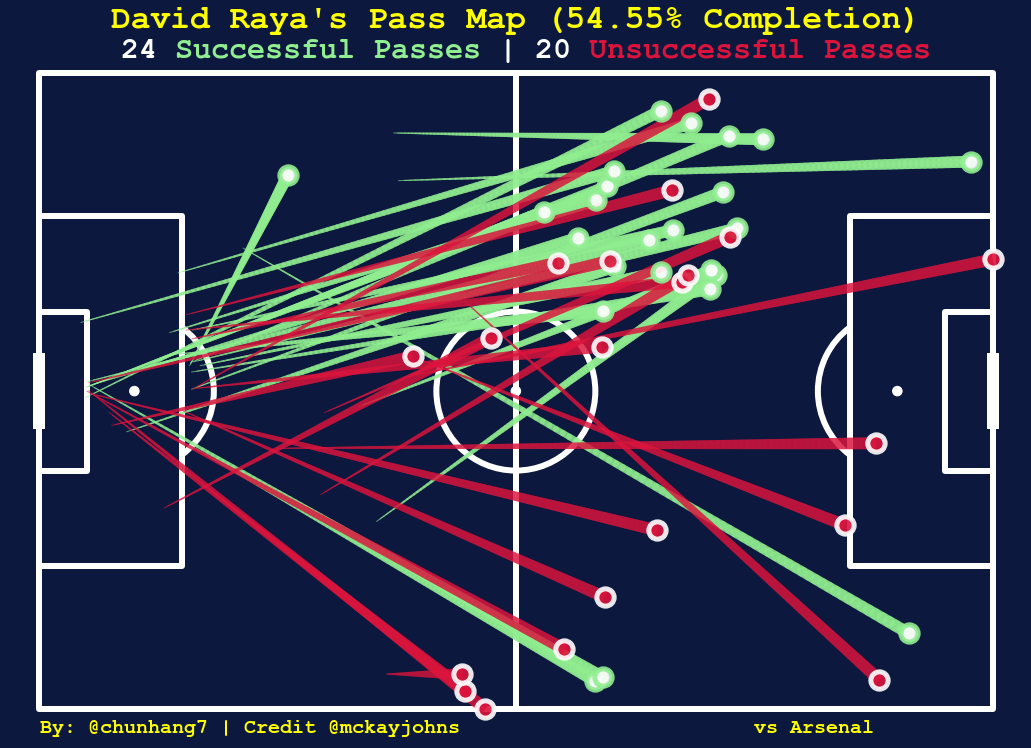

In [5]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Plot Successful Passes
pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(Successful_Passes['endX'], Successful_Passes['endY'],
              edgecolors= "lightgreen", c="w", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

#Plot Unsuccessful Passes
pitch.lines(Unsuccessful_Passes.x,Unsuccessful_Passes.y,Unsuccessful_Passes.endX,Unsuccessful_Passes.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.6, color ='crimson')

pitch.scatter(Unsuccessful_Passes['endX'], Unsuccessful_Passes['endY'],
              edgecolors= "w", c="crimson", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Unsuccessful Passes')

#Plot Assists
if Assist.empty == False:
    pitch.lines(Assist.x,Assist.y,Assist.endX,Assist.endY,
                comet=True,ax=ax, linewidth=12, capstyle='round', 
                alpha=0.6, color ='orange')
    
    pitch.scatter(Assist['endX'], Assist['endY'],
                  edgecolors= "orange", c="w", s = 300, zorder=4, ax=ax, 
                  marker = 'o', alpha = 0.9,linewidths=5, label='Assists')
    
#Title & Annotations
fig.suptitle(player +"'s Pass Map ("+str(completion)+"% Completion)\n", fontsize=33, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.94)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "crimson","fontweight": 'bold'}
    ]

Title = fig_text(s = str(successful) + " <Successful Passes> | " + str(unsuccessful) + " <Unsuccessful Passes>" ,
        x = 0.509, y = 0.9, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Credits
ax.text(0.1, -2.5, 'By: @chunhang7 | Credit @mckayjohns', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(90, -2.5, "vs "+ oppo, va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

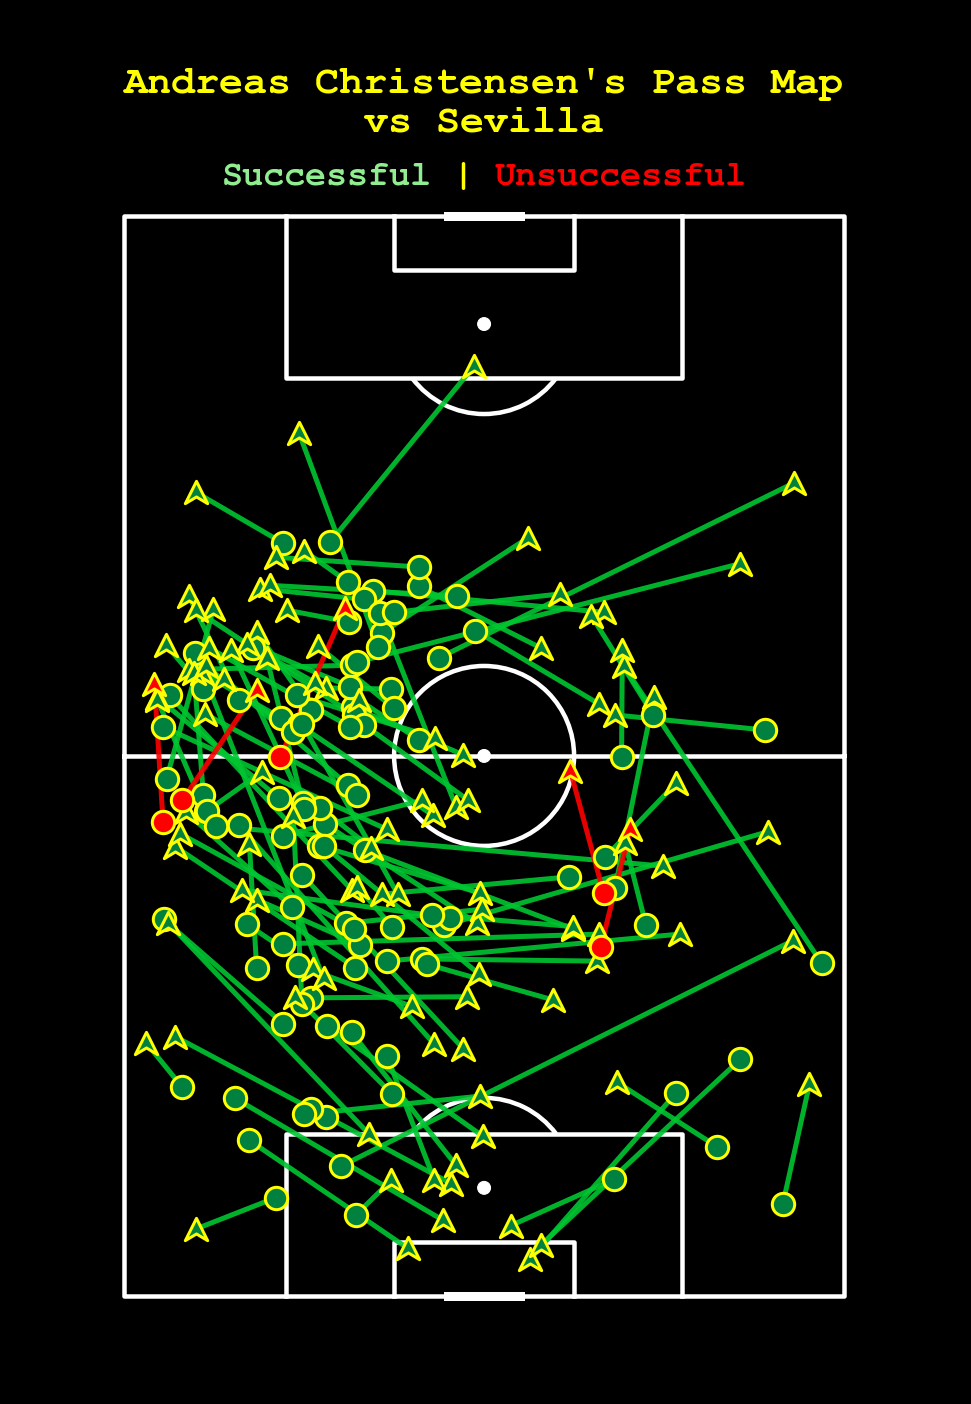

In [23]:
#Set up pitch
#mpl.rcParams['figure.dpi'] = 300
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Successful Passes
pitch.scatter(Successful_Passes.x,Successful_Passes.y, edgecolors= 'yellow', c='#008140',
              s = 500, zorder=4, ax=ax, marker = 'o', linewidth=3)

pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            ax=ax, color= '#00c631', lw=5, alpha = 0.9)

pitch.scatter(Successful_Passes.endX,Successful_Passes.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 500, zorder=4, ax=ax, linewidth=3)

#Unsuccessful Passes
pitch.scatter(Unsuccessful_Passes.x,Unsuccessful_Passes.y, edgecolors= 'yellow', c='red',
              s = 500, zorder=6, ax=ax, marker = 'o', linewidth=3)

pitch.lines(Unsuccessful_Passes.x,Unsuccessful_Passes.y,Unsuccessful_Passes.endX,Unsuccessful_Passes.endY,
            ax=ax, color= 'red', lw=5, alpha = 0.9)

pitch.scatter(Unsuccessful_Passes.endX,Unsuccessful_Passes.endY, edgecolors= 'yellow', c='red',marker=arrowhead_marker,
              s = 500, zorder=6, ax=ax, linewidth=3)

#Title
plt.text(40,121,player+"'s Pass Map\nvs Sevilla\n\n",color='yellow', ha='center',
          size=40, fontfamily = "Courier New", fontweight = "bold")

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "red","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Successful> | <Unsuccessful>",
        x = 0.5, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35)

#Space
ax.text(45, 142, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(93, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

plt.show()

# Heatmaps

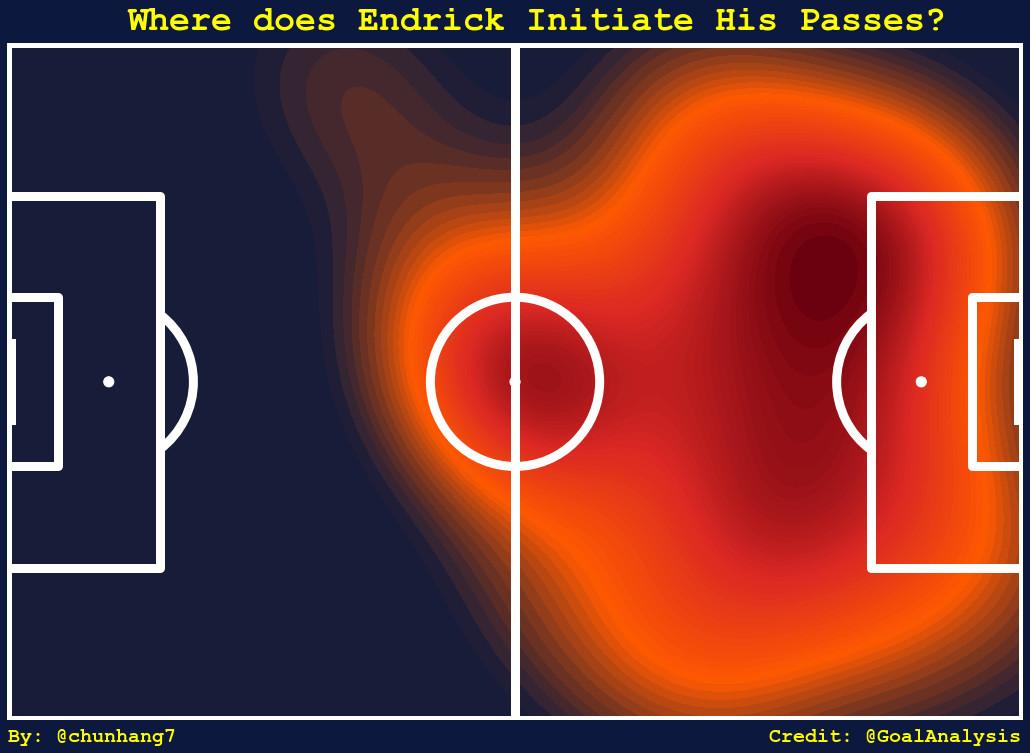

In [6]:
#Set Colors for heatmaps
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#171c38','#fd5901','#db2824','#67000d'])

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=9, spot_scale=0.005,line_zorder=1)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)

#Heatmaps of progressive passes origin
kde = sns.kdeplot(All_Passes['x'], All_Passes['y'], shade = True, 
                  shade_lowest= False, n_levels=50, linewidths=3, alpha=1, zorder=0.5, cmap=customcmap)

#Title & Annotations
fig.suptitle("Where does "+player+" Initiate His Passes?", fontsize=35, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")str(completion)+"% Completion

ax.text(90, -2, 'Credit: @GoalAnalysis', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

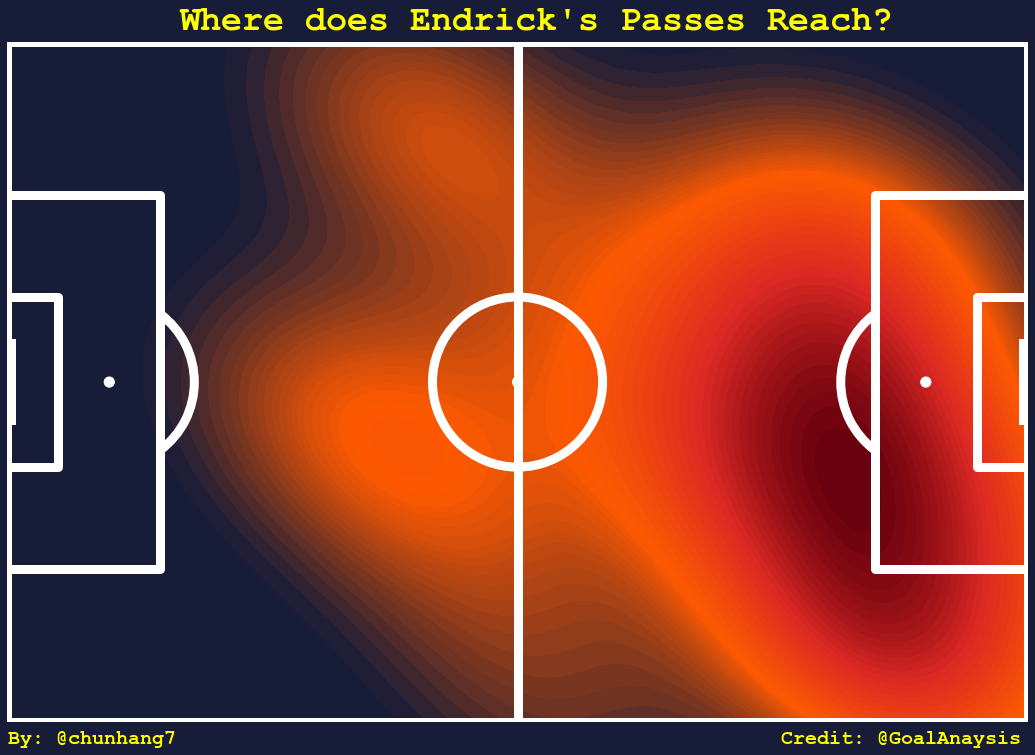

In [7]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=9, spot_scale=0.005,line_zorder=1)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Set plot boundaries
plt.xlim(0,120)
plt.ylim(0,80)

#Heatmaps of progressive passes origin
kde = sns.kdeplot(Successful_Passes['endX'], Successful_Passes['endY'], shade = True, 
                  shade_lowest= False, n_levels=50, linewidths=3, alpha=1, zorder=0.5, cmap=customcmap)

#Title & Annotations
fig.suptitle("Where does "+player+"'s Passes Reach?", fontsize=35, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(91, -2, 'Credit: @GoalAnaysis', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

# Vertical Pitch

#Make the Vertical pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#c21821', line_color='white',half = False,
                  line_zorder=1, linewidth=4.5, spot_scale=0.006)

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#c21821')

#inverse y-axis
plt.gca().invert_xaxis()


#Plot Successful Passes
pitch.lines(Successful_Passes.x,Successful_Passes.y,Successful_Passes.endX,Successful_Passes.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(Successful_Passes['endX'], Successful_Passes['endY'],
              edgecolors= "lightgreen", c="w", s = 250, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

#Plot Unsuccessful Passes
pitch.lines(Unsuccessful_Passes.x,Unsuccessful_Passes.y,Unsuccessful_Passes.endX,Unsuccessful_Passes.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.6, color ='black')

pitch.scatter(Unsuccessful_Passes['endX'], Unsuccessful_Passes['endY'],
              edgecolors= "black", c="yellow", s = 250, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Unsuccessful Passes')

#Plot Assists
if Assist.empty == False:
    pitch.lines(Assist.x,Assist.y,Assist.endX,Assist.endY,
                comet=True,ax=ax, linewidth=12, capstyle='round', 
                alpha=0.6, color ='orange')
    
    pitch.scatter(Assist['endX'], Assist['endY'],
                  edgecolors= "orange", c="w", s = 250, zorder=4, ax=ax, 
                  marker = 'o', alpha = 0.9,linewidths=10, label='Assists')

# Pass Clusters

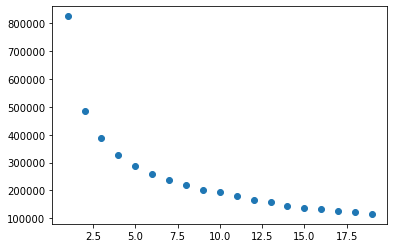

In [8]:
#Use either All_Passes or Successful_Passes dataframe

# Elbow Method: determining how many clusters to use in the final plots
K = range(1,20)
wss= []
for k in K:
    array = np.array(All_Passes[['x', 'y', 'endX', 'endY','passlength']])
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(array)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters':K, 'WSS':wss})
mycenters
# Reading the results of the Elbow Method: imagine the shape created
# by this scatter plot as one of an arm. The part best-resembling an elbow
# is considered the "ideal" amount of clusters to use
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

In [9]:
# Clustering the passes. Note that n_clusters = the result from the scatter
# plot above and is inputted manually
array = np.array(All_Passes[['x', 'y', 'endX', 'endY','passlength']])
kmeans = KMeans(n_clusters = 10, random_state = 100)
kmeans.fit(array)
All_Passes['cluster'] = kmeans.predict(array)

# Creates list to index most frequent clusters
art = All_Passes.cluster.value_counts().index.tolist()[0:3]

# Filtering for clusters
cluster1 = All_Passes[All_Passes['cluster'] == art[0]]
cluster2 = All_Passes[All_Passes['cluster'] == art[1]]
cluster3 = All_Passes[All_Passes['cluster'] == art[2]]

C:\Users\user\AppData\Local\Temp/ipykernel_16968/1030344918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  All_Passes['cluster'] = kmeans.predict(array)


In [10]:
#Find Average location of the passes 
cluster1avg = cluster1.groupby('playername').agg({'x': ['mean'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster1avg.columns = ['x', 'y', 'endX','endY']

cluster2avg = cluster2.groupby('playername').agg({'x': ['mean'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster2avg.columns = ['x', 'y', 'endX','endY']

cluster3avg = cluster3.groupby('playername').agg({'x': ['mean'], 'y': ['mean'], 'endX': ['mean'], 'endY': ['mean']})
cluster3avg.columns = ['x', 'y', 'endX','endY']

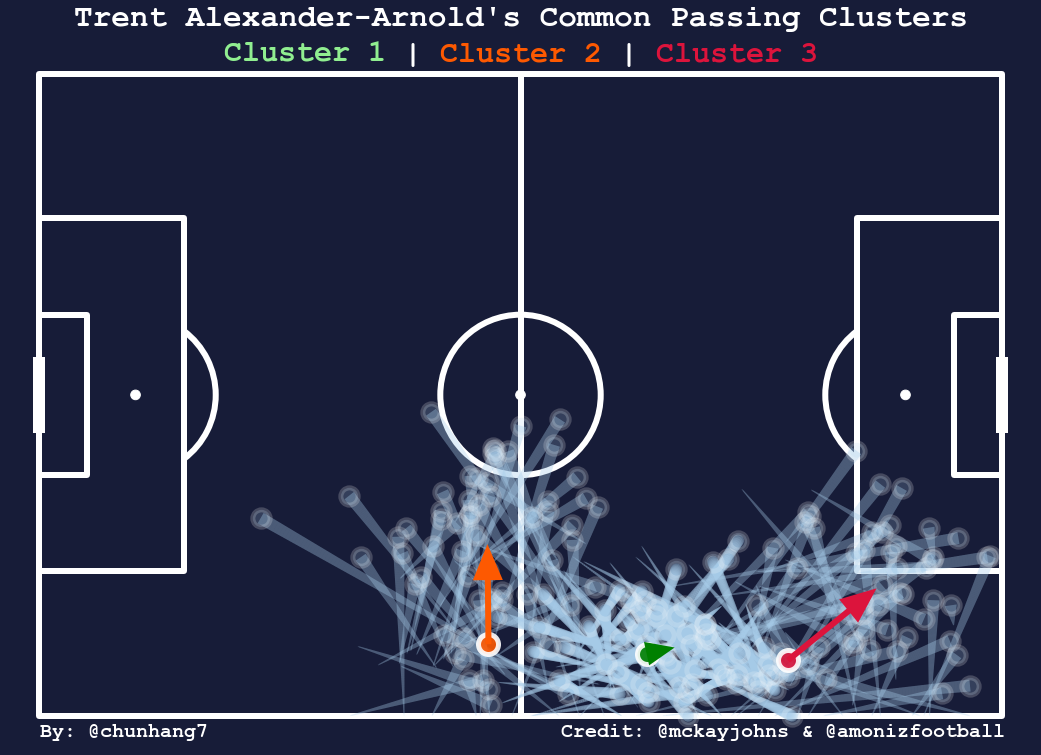

In [11]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#171c38', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#171c38')

#Inverse y-axis
plt.gca().invert_yaxis()

#Plot cluster1
pitch.lines(cluster1.x,cluster1.y,cluster1.endX,cluster1.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster1['endX'], cluster1['endY'],
              edgecolors= "w", c="#aacfec", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=5)

#Plot cluster2
pitch.lines(cluster2.x,cluster2.y,cluster2.endX,cluster2.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster2['endX'], cluster2['endY'],
              edgecolors= "w", c="#aacfec", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=5)

#Plot cluster3
pitch.lines(cluster3.x,cluster3.y,cluster3.endX,cluster3.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.2, color ='#aacfec')

pitch.scatter(cluster3['endX'], cluster3['endY'],
              edgecolors= "w", c="#aacfec", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.2,linewidths=5)

#Plot cluster1
pitch.arrows(cluster1avg.x,cluster1avg.y,cluster1avg.endX,cluster1avg.endY, zorder= 5
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='green')

pitch.scatter(cluster1avg['x'], cluster1avg['y'],
              edgecolors= "w", c="green", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster2
pitch.arrows(cluster2avg.x,cluster2avg.y,cluster2avg.endX,cluster2avg.endY, zorder= 5
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='#fd5901')

pitch.scatter(cluster2avg['x'], cluster2avg['y'],
              edgecolors= "w", c="#fd5901", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)

#Plot cluster2
pitch.arrows(cluster3avg.x,cluster3avg.y,cluster3avg.endX,cluster3avg.endY, zorder= 5
            ,ax=ax, width=6, headwidth=5, headlength=6, headaxislength=6,color ='crimson')

pitch.scatter(cluster3avg['x'], cluster3avg['y'],
              edgecolors= "w", c="crimson", s = 400, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5)


#Title & Annotations
fig.suptitle(player +"'s Common Passing Clusters\n", fontsize=31, color='w',
            fontfamily = "Courier New", fontweight = "bold",y=0.95)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#fd5901","fontweight": 'bold'},
     {"color": "crimson","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Cluster 1> | <Cluster 2> | <Cluster 3>" ,
        x = 0.5, y = 0.905, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Credits
ax.text(0.1, -2, 'By: @chunhang7', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(65, -2, 'Credit: @mckayjohns & @amonizfootball', va='center', ha='left', fontsize=20, color='w',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

"""
#Concatenation
#dropping name and team. to concatenate table
successful_pass_list = successful_pass_list.drop(['playername','teamId'], axis = 1)

#Concatenate two tables and display table accordingly
Passes = pd.concat([pass_list, successful_pass_list], axis=1)
Passes = Passes.sort_values('Attempted Passes', ascending= False).reset_index(drop = True)
Passes
"""